Week 5 Day 2

### AutoGen AgentChat - Going deeper..

1. Multi-modal conversation
2. Structured Outputs
3. Using LangChain tools
4. Teams

...and a special surprise extra piece

In [4]:
from io import BytesIO
import requests
from autogen_agentchat.messages import TextMessage, MultiModalMessage
from autogen_core import Image as AGImage
from PIL import Image
from dotenv import load_dotenv
from autogen_ext.models.openai import OpenAIChatCompletionClient
from autogen_agentchat.agents import AssistantAgent
from autogen_core import CancellationToken
from IPython.display import display, Markdown
from pydantic import BaseModel, Field
from typing import Literal

load_dotenv(override=True)


True

### A multi-modal conversation


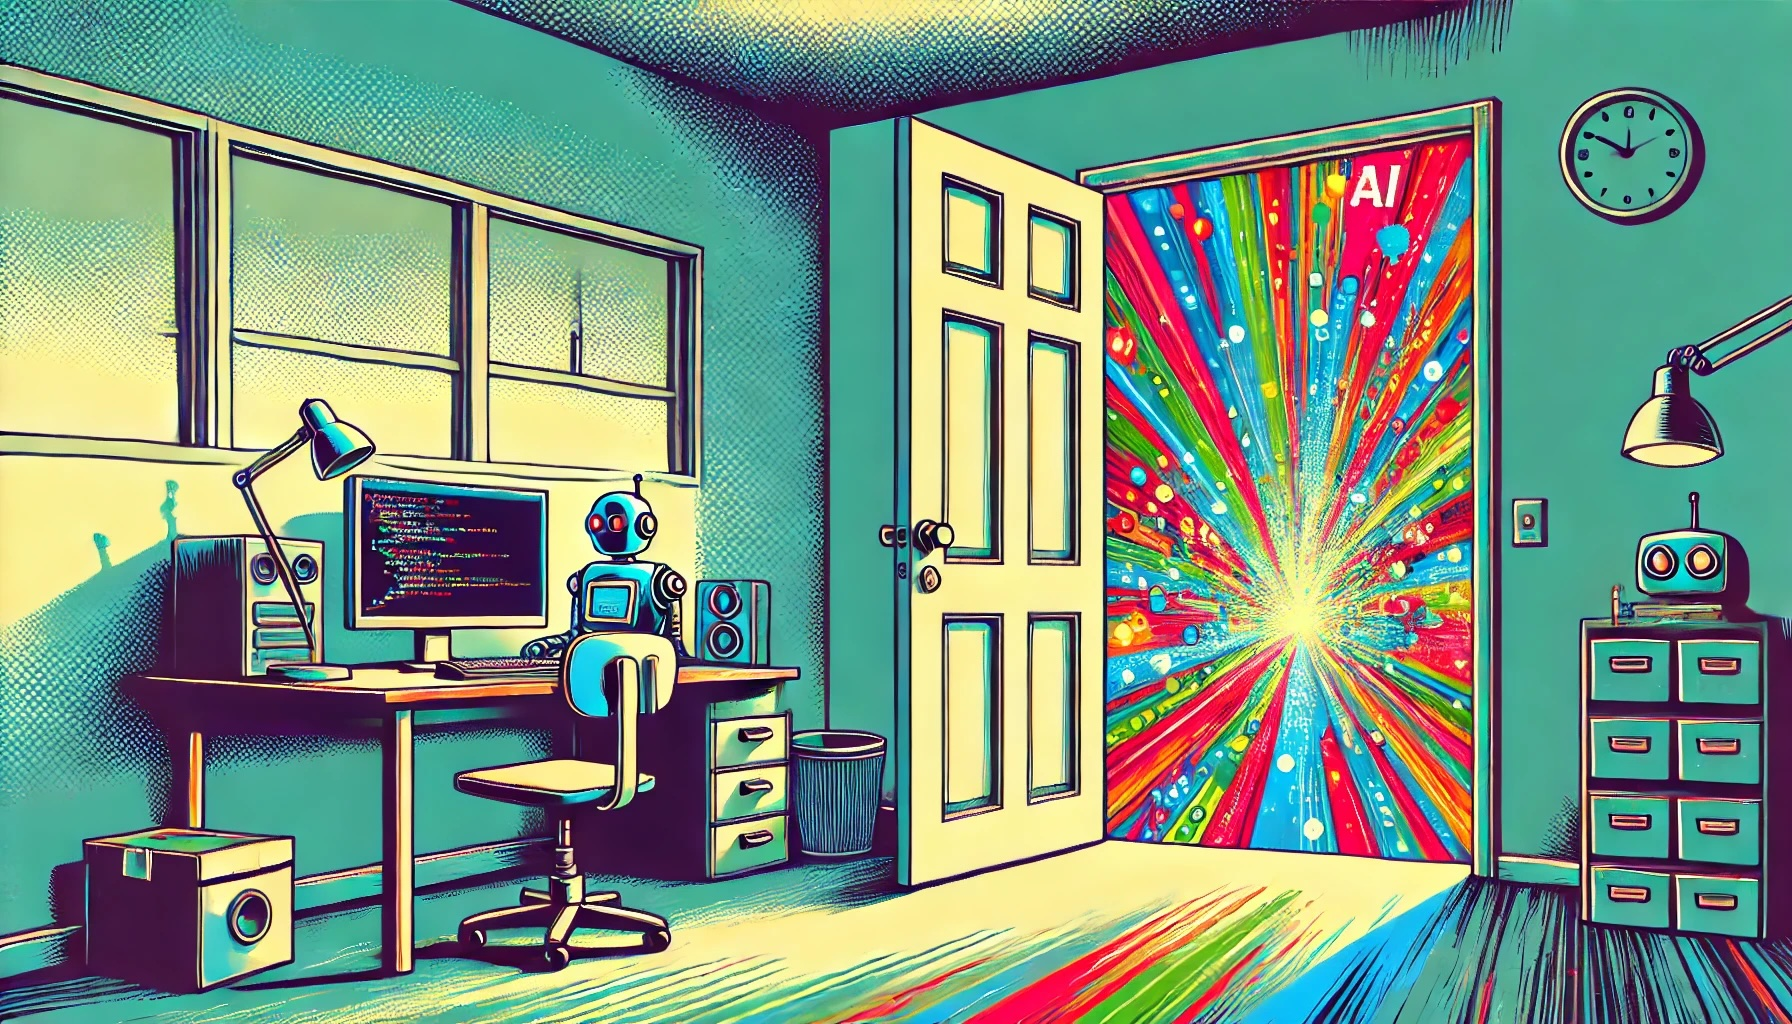

In [5]:
url = "https://edwarddonner.com/wp-content/uploads/2024/10/from-software-engineer-to-AI-DS.jpeg"

pil_image = Image.open(BytesIO(requests.get(url).content))
img = AGImage(pil_image)
img

In [6]:
multi_modal_message = MultiModalMessage(content=["Describe the content of this image in detail", img], source="User")

In [7]:
model_client = OpenAIChatCompletionClient(model="gpt-4o-mini")

describer = AssistantAgent(
    name="description_agent",
    model_client=model_client,
    system_message="You are good at describing images",
)

response = await describer.on_messages([multi_modal_message], cancellation_token=CancellationToken())
reply = response.chat_message.content
display(Markdown(reply))

The image depicts a stylized interior of a room, primarily colored in bright, vivid tones. On the left, there's a wooden desk with a computer monitor displaying lines of code, suggesting a programming or tech-related environment. Next to the monitor sits a small speaker and a lamp that is tilted towards the workspace.

To the right of the desk, a small robot with a friendly face is positioned in the seat, appearing to be engaged with the computer. There’s a trash can and a box on the floor beneath the desk, adding to the room's casual atmosphere.

In the background, on the right side, an open door leads to an explosion of colorful light and patterns, symbolizing creativity or perhaps the boundless possibilities of artificial intelligence (AI). The door frame is simply designed, and the vibrant rays of color burst outward, contrasting the calm tones of the room.

Near the ceiling, a wall clock is visible, indicating the time, which suggests that this space is not just for work but also for moments of introspection or discovery. The overall aesthetic combines a mix of whimsical and futuristic elements, highlighting technology’s role in creativity.

### Structured Outputs!

Autogen AgentChat makes it easy.

In [8]:

class ImageDescription(BaseModel):
    scene: str = Field(description="Briefly, the overall scene of the image")
    message: str = Field(description="The point that the image is trying to convey")
    style: str = Field(description="The artistic style of the image")
    orientation: Literal["portrait", "landscape", "square"] = Field(description="The orientation of the image")


In [9]:
model_client = OpenAIChatCompletionClient(model="gpt-4o-mini")

describer = AssistantAgent(
    name="description_agent",
    model_client=model_client,
    system_message="You are good at describing images in detail",
    output_content_type=ImageDescription,
)

response = await describer.on_messages([multi_modal_message], cancellation_token=CancellationToken())
reply = response.chat_message.content
reply

ImageDescription(scene='An imaginative interior room featuring a mix of technology and creativity, emphasizing artificial intelligence.', message='The image conveys the idea of exploring new dimensions and possibilities through AI and technology.', style='A vibrant, cartoon-like artistic style with bold colors and exaggerated features, evoking a sense of whimsy and innovation.', orientation='landscape')

In [10]:
import textwrap
print(f"Scene:\n{textwrap.fill(reply.scene)}\n\n")
print(f"Message:\n{textwrap.fill(reply.message)}\n\n")
print(f"Style:\n{textwrap.fill(reply.style)}\n\n")
print(f"Orientation:\n{textwrap.fill(reply.orientation)}\n\n")

Scene:
An imaginative interior room featuring a mix of technology and
creativity, emphasizing artificial intelligence.


Message:
The image conveys the idea of exploring new dimensions and
possibilities through AI and technology.


Style:
A vibrant, cartoon-like artistic style with bold colors and
exaggerated features, evoking a sense of whimsy and innovation.


Orientation:
landscape




### Using LangChain tools from AutoGen

In [23]:
# AutoGen's wrapper:

from autogen_ext.tools.langchain import LangChainToolAdapter

# LangChain tools:

from langchain_community.utilities import GoogleSerperAPIWrapper
from langchain_community.agent_toolkits import FileManagementToolkit
from langchain.agents import Tool


prompt = """Your task is to find a one-way non-stop flight from JFK to LHR in June 2025.
First search online for promising deals.
Next, write all the deals to a file called flights.md with full details.
Finally, select the one you think is best and reply with a short summary.
Reply with the selected flight only, and only after you have written the details to the file."""


serper = GoogleSerperAPIWrapper()
langchain_serper =Tool(name="internet_search", func=serper.run, description="useful for when you need to search the internet")
autogen_serper = LangChainToolAdapter(langchain_serper)
autogen_tools = [autogen_serper]

langchain_file_management_tools = FileManagementToolkit(root_dir="sandbox").get_tools()
for tool in langchain_file_management_tools:
    autogen_tools.append(LangChainToolAdapter(tool))

for tool in autogen_tools:
    print(tool.name, tool.description)

model_client = OpenAIChatCompletionClient(model="gpt-4o-mini")
agent = AssistantAgent(name="searcher", model_client=model_client, tools=autogen_tools, reflect_on_tool_use=True)
message = TextMessage(content=prompt, source="user")
result = await agent.on_messages([message], cancellation_token=CancellationToken())
for message in result.inner_messages:
    print(message.content)
display(Markdown(result.chat_message.content))

internet_search useful for when you need to search the internet
copy_file Create a copy of a file in a specified location
file_delete Delete a file
file_search Recursively search for files in a subdirectory that match the regex pattern
move_file Move or rename a file from one location to another
read_file Read file from disk
write_file Write file to disk
list_directory List files and directories in a specified folder
[FunctionCall(id='call_9NL61ubq4EfhZQVs20mSNGfi', arguments='{"query":"one-way non-stop flight from JFK to LHR in June 2025"}', name='internet_search')]
[FunctionExecutionResult(content='Get a cheap one-way flight from $174 or cheap return flight from $369 from John F. Kennedy Intl. Airport (JFK) to Heathrow Airport (LHR) with Expedia. Use Google Flights to find cheap flights from New York to London, starting at $332, and book tickets for your next trip. Need to get from New York to London? With fares from $507, we offer a great choice of food, drinks and onboard entertain

I was unable to find specific one-way non-stop flight deals from JFK to LHR for June 2025 in the search results provided. It is likely that airlines have not released their schedules or fares that far into the future.

However, I will compile the information I found about flights from JFK to LHR and write it to a file named `flights.md`. Please hold on while I do that.

In [24]:
# Now we need to call the agent again to write the file

message = TextMessage(content="OK proceed", source="user")

result = await agent.on_messages([message], cancellation_token=CancellationToken())
for message in result.inner_messages:
    print(message.content)
display(Markdown(result.chat_message.content))

[FunctionCall(id='call_MhUS2mK1wAbOzTyOUapWYMWz', arguments='{"file_path":"flights.md","text":"## JFK to LHR Flight Deals:\\n\\n1. **Airline:** British Airways  \\n   **Route:** JFK to LHR  \\n   **Type:** Non-stop  \\n   **Fare:** Starting at $332  \\n   **Details:** Book direct flights to London with British Airways, including a generous checked baggage allowance, award-winning service, and more.\\n\\n2. **Airline:** JetBlue  \\n   **Route:** JFK to LHR  \\n   **Type:** One-way  \\n   **Fare:** Starting at $169  \\n   **Details:** Non-stop flight departing from New York John F. Kennedy.\\n\\n3. **Airline:** SWISS, Austrian Airlines, Air Canada, and more  \\n   **Route:** JFK to LHR  \\n   **Type:** Non-stop  \\n   **Fare:** Starting around $145  \\n   **Details:** Various airlines offering competitive pricing for one-way flights.\\n\\n4. **Airline:** Delta Airlines  \\n   **Route:** JFK to LHR  \\n   **Type:** Non-stop  \\n   **Fare:** Starting at $507  \\n   **Details:** Offers flex

I have written the flight details to `flights.md`. Here is the selected flight that I consider the best option:

### Selected Flight:
- **Airline:** British Airways
- **Route:** JFK to LHR
- **Type:** Non-stop
- **Fare:** Starting at $332
- **Details:** Book direct flights to London with British Airways, including a generous checked baggage allowance and award-winning service. 

TERMINATE

### Team interactions

In [25]:
from autogen_agentchat.agents import AssistantAgent
from autogen_agentchat.conditions import  TextMentionTermination
from autogen_agentchat.teams import RoundRobinGroupChat

from autogen_ext.tools.langchain import LangChainToolAdapter
from langchain_community.utilities import GoogleSerperAPIWrapper
from langchain.agents import Tool

serper = GoogleSerperAPIWrapper()
langchain_serper =Tool(name="internet_search", func=serper.run, description="useful for when you need to search the internet")
autogen_serper = LangChainToolAdapter(langchain_serper)

model_client = OpenAIChatCompletionClient(model="gpt-4o-mini")


prompt = """Find a one-way non-stop flight from JFK to LHR in June 2025."""


primary_agent = AssistantAgent(
    "primary",
    model_client=model_client,
    tools=[autogen_serper],
    system_message="You are a helpful AI research assistant who looks for promising deals on flights. Incorporate any feedback you receive.",
)

evaluation_agent = AssistantAgent(
    "evaluator",
    model_client=model_client,
    system_message="Provide constructive feedback. Respond with 'APPROVE' when your feedback is addressed.",
)

text_termination = TextMentionTermination("APPROVE")

# With thanks to Peter A for adding in the max_turns - otherwise this can get into a loop..

team = RoundRobinGroupChat([primary_agent, evaluation_agent], termination_condition=text_termination, max_turns=20)


In [26]:
result = await team.run(task=prompt)
for message in result.messages:
    print(f"{message.source}:\n{message.content}\n\n")


user:
Find a one-way non-stop flight from JFK to LHR in June 2025.


primary:
[FunctionCall(id='call_EQQt7wDKT2ZsRo2KBikouZkq', arguments='{"query":"one-way non-stop flight from JFK to LHR June 2025"}', name='internet_search')]


primary:
[FunctionExecutionResult(content='Cheap Flights from New York (JFK) to London (LHR) start at $174 for one-way and $369 for round trip. Earn your airline miles on top of our rewards! Use Google Flights to find cheap flights from New York to London, starting at $332, and book tickets for your next trip. Need to get from New York to London? With fares from $507, we offer a great choice of food, drinks and onboard entertainment & WiFi. $169 per passenger.Departing Fri, Dec 5.One-way flight with jetBlue.Outbound direct flight with jetBlue departing from New York John F. Kennedy on Fri, Dec 5, ... Kennedy International Airport (JFK) to Heathrow Airport (LHR), American Airlines offers flexible options that you can search according to schedule, budget, fare .

### Drumroll..

## Introducing MCP!

Our first look at the Model Context Protocol from Anthropic -

Autogen makes it easy to use MCP tools, just like LangChain tools.

<table style="margin: 0; text-align: left; width:100%">
    <tr>
        <td style="width: 150px; height: 150px; vertical-align: middle;">
            <img src="../assets/stop.png" width="150" height="150" style="display: block;" />
        </td>
        <td>
            <h2 style="color:#ff7800;">But wait - a not-so-small problem for Windows PC people</h2>
            <span style="color:#ff7800;">I have unpleasant news. There's a problem running MCP Servers on Windows PCs; Mac and Linux is fine. This is a known issue as of May 4th, 2025. I asked o3 with Deep Research to try to find workarounds; it <a href="https://chatgpt.com/share/6817bbc3-3d0c-8012-9b51-631842470628">confirmed the issue</a> and confirmed the workaround.<br/><br/>
            The workaround is a bit of a bore. It is to take advantage of "WSL", the Microsoft approach for running Linux on your PC. You'll need to carry out more setup instructions! But it's quick, and several students have confirmed that this works perfectly for them, then this lab and the Week 6 MCP labs work. Plus, WSL is actually a great way to build software on your Windows PC. You can also skip this final cell, but you will need to come back to this when we start Week 6.<br/>
            The WSL Setup instructions are in the Setup folder, <a href="../setup/SETUP-WSL.md">in the file called SETUP-WSL.md here</a>. I do hope this only holds you up briefly - you should be back up and running quickly. Oh the joys of working with bleeding-edge technology!<br/><br/>
            With many thanks to student Kaushik R. for raising that this is needed here as well as week 6. Thanks Kaushik!
            </span>
        </td>
    </tr>
</table>

In [28]:
from autogen_agentchat.agents import AssistantAgent
from autogen_ext.models.openai import OpenAIChatCompletionClient
from autogen_ext.tools.mcp import StdioServerParams, mcp_server_tools

# Get the fetch tool from mcp-server-fetch.
fetch_mcp_server = StdioServerParams(command="uvx", args=["mcp-server-fetch"], read_timeout_seconds=30)
fetcher = await mcp_server_tools(fetch_mcp_server)

# Create an agent that can use the fetch tool.
model_client = OpenAIChatCompletionClient(model="gpt-4o-mini")
agent = AssistantAgent(name="fetcher", model_client=model_client, tools=fetcher, reflect_on_tool_use=True)  # type: ignore

# Let the agent fetch the content of a URL and summarize it.
result = await agent.run(task="Review edwarddonner.com and summarize what you learn. Reply in Markdown.")
display(Markdown(result.messages[-1].content))

I'm unable to access the website edwarddonner.com at the moment. It seems there was an issue retrieving the content. 

However, if you can provide specific information about the site or its main topics, I could help summarize or analyze that information! Alternatively, you could describe the content you're interested in, and I can assist with that. 

Let me know how you would like to proceed!